In [1]:
import librosa
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from PIL import Image

**Common function**

In [21]:
%matplotlib inline

In [51]:
def plot_spectrogram(in_val):
    fig = plt.figure()
    librosa.display.specshow(
        in_val.T,
        sr=22050,
        hop_length=256,
        x_axis="time",
        y_axis="linear",
        fmin=50,
        fmax=76000,
    )
    plt.xlabel("Time", fontsize=16)
    plt.ylabel("Hz", fontsize=16)
    plt.tight_layout()
    plt.colorbar()
    plt.show()

def plot_waveform(waveform, sample_rate=22050):
    """
    Plots a waveform with the given sample rate.

    Parameters:
    - waveform: The input waveform (1D array or a list of amplitudes).
    - sample_rate: The sample rate of the waveform (default is 22050 Hz).
    """
    # Create a time axis in seconds
    time = np.linspace(0., len(waveform) / sample_rate, num=len(waveform))
    
    # Plot the waveform
    plt.figure(figsize=(10, 4))
    plt.plot(time, waveform, label="Waveform")
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title('Waveform of the Audio')
    plt.legend()
    plt.show()

In [47]:
tts_model_dir = "./pretrain_model/tts_models--ja--kokoro--tacotron2-DDC"
vocoder_model_dir = "./pretrain_model/vocoder_models--ja--kokoro--hifigan_v1"

# 1. Using TTS models

In [4]:
import torch
from TTS.api import TTS
import soundfile as sf
from IPython.display import Audio
import os

In [ ]:
tts = TTS(model_path=os.path.join(tts_model_dir, "model_file.pth"),
          config_path=os.path.join(tts_model_dir, "config.json"),
          vocoder_path=os.path.join(vocoder_model_dir, "model_file.pth"),
          vocoder_config_path=os.path.join(vocoder_model_dir, "config.json"),
          gpu=False)

TTS.is_multi_lingual = False

In [6]:
text = "こんにちは！はじめまして、よろしくお願いいたします"  
wav = tts.tts(text)
display(Audio(wav, rate=22050))

 > Text splitted to sentences.
['こんにちは！', 'はじめまして、よろしくお願いいたします']
koNnichiwa*
 [!] Character '*' not found in the vocabulary. Discarding it.
 > Processing time: 11.631115674972534
 > Real-time factor: 2.554850380868907


# 2. TTS model detail

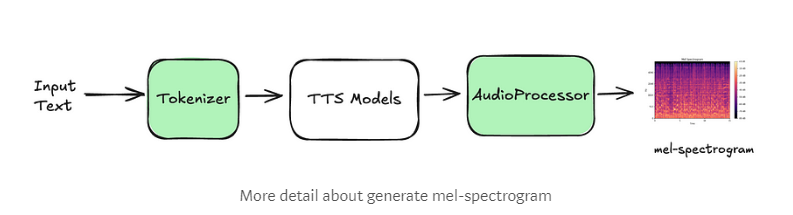

In [7]:
from TTS.config import load_config
from TTS.tts.utils.text.tokenizer import TTSTokenizer
from TTS.utils.audio import AudioProcessor
from TTS.tts.models.tacotron2 import Tacotron2
import numpy as np

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Step 1. Load config file
config_path = os.path.join(tts_model_dir, "config.json")
config = load_config(config_path)

# Step 2. Load tokenizer
tokenizer, new_config = TTSTokenizer.init_from_config(config)

# Step 3. Load audio processor
ap = AudioProcessor.init_from_config(config)

# Step 4. Load TTS models
model = Tacotron2(new_config, ap, tokenizer, None)
model.load_checkpoint(config, os.path.join(tts_model_dir, "model_file.pth"), eval=True)
model = model.cuda()

## 1. Check tokenizer

In [10]:
tokenizer.phonemizer.phonemize("初めまして、よろしくお願いいたします。")

'h|a|j|i|m|e|m|a|s|h|i|t|e|,|y|o|r|o|s|h|i|k|u|o|n|e|g|a|i|i|t|a|s|h|i|m|a|s|u|.'

In [11]:
ids = tokenizer.text_to_ids("こんにちは")
print(ids)

[39, 43, 16, 42, 37, 31, 36, 37, 51, 29]


In [12]:
tokenizer.ids_to_text(ids)

'koNnichiwa'

## 2. Inference

In [39]:
# Step 1. Convert text to ids with tokenizer
input_ids = tokenizer.text_to_ids("こんにちは")

# Step 2. Feed to models
input_ids = np.asarray(input_ids, dtype=np.int32)
input_ids = torch.as_tensor(input_ids, dtype=torch.long, device="cuda")
input_ids = input_ids.unsqueeze(0)

output = model.inference(input_ids)['model_outputs'][0]

# Step 3. Denormalize output
mel_postnet_spec = output.detach().cpu().numpy()
mel_postnet_spec = ap.denormalize(mel_postnet_spec.T).T

In [40]:
mel_postnet_spec.shape

(78, 80)

**Visualize output from model**

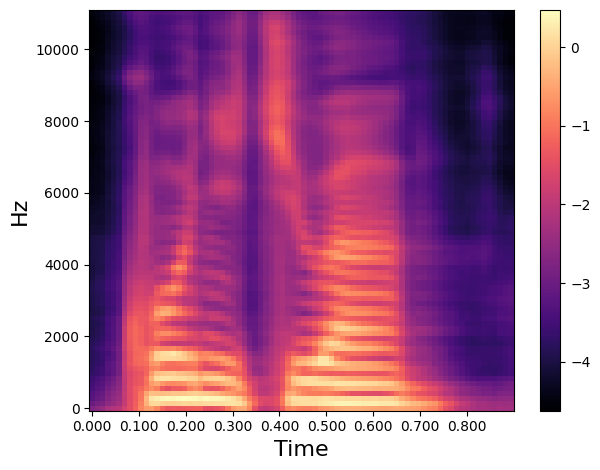

In [41]:
plot_spectrogram(mel_postnet_spec)

## 4. Vocoder

In [42]:
from TTS.vocoder.models.gan import GAN
from TTS.vocoder.models import setup_model as setup_vocoder_model

## 4.1 Load Vocoder Audio Processor, vocoder model

In [ ]:
vocoder_config = load_config(os.path.join(vocoder_model_dir, "config.json"))
vocoder_ap = AudioProcessor(verbose=False, **vocoder_config.audio)

# Load model
vocoder_model = GAN.init_from_config(vocoder_config)
vocoder_model.load_checkpoint(vocoder_config, os.path.join(vocoder_model_dir, "model_file.pth"), eval=True)

**Normalize audio**

In [44]:
mel_spec = vocoder_ap.normalize(mel_postnet_spec.T)
mel_spec = torch.tensor(mel_spec).unsqueeze(0).to("cuda")

waveform = vocoder_model.inference(mel_spec).cpu().numpy().squeeze()

**Play audio**

In [46]:
display(Audio(waveform, rate=22050))

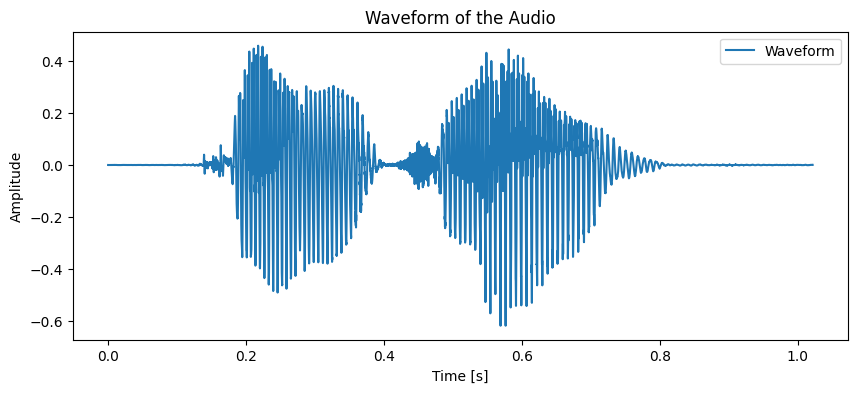

In [52]:
plot_waveform(waveform)